# Hex Game AI Analysis
This notebook analyzes the performance statistics of different AI engines in the Hex game.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [11]:
import glob
import re
import os
import pandas as pd
from datetime import datetime

def load_hex_data():
    """Load Hex game statistics with interactive file selection"""
    
    # Look for hex stats files
    path = "../Data"
    csv_files = glob.glob(path+"/hex_stats*.csv")
    
    if not csv_files:
        print("No hex_stats*.csv files found in Data directory.")
        csv_file = input("Please enter CSV filename: ").strip()
        if not os.path.exists("../Data/"+csv_file):
            print(f"File {csv_file} not found. Please check the filename.")
            return None, None, None
    else:
        print("\nAvailable Hex statistics files:")
        print("-" * 50)
        
        file_info = []
        for f in csv_files:
            # Parse filename for detailed info display
            metadata = extract_metadata(f)
            display_parts = []
            
            if 'board_size' in metadata:
                display_parts.append(f"Board {metadata['board_size']}x{metadata['board_size']}")
            if 'threads' in metadata:
                display_parts.append(f"{metadata['threads']} threads")
            if 'games' in metadata:
                display_parts.append(f"{metadata['games']} games")
            if 'date' in metadata:
                display_parts.append(f"{metadata['date']}")
                
            if display_parts:
                display = ", ".join(display_parts) + f" - {f}"
            else:
                display = f
            file_info.append((f, display))
        
        for i, (f, display) in enumerate(file_info, 1):
            print(f"{i:2d}. {display}")
        
        print(f"{len(file_info)+1:2d}. Enter custom filename")
        
        while True:
            choice = input(f"\nSelect file [1-{len(file_info)+1}]: ").strip()
            if choice.isdigit():
                choice_num = int(choice)
                if 1 <= choice_num <= len(file_info):
                    csv_file = file_info[choice_num-1][0]
                    break
                elif choice_num == len(file_info) + 1:
                    csv_file = input("Enter custom filename: ").strip()
                    break
            print("Please enter a valid number.")
    
    # Load data
    try:
        df = pd.read_csv(csv_file)
        print(f"✓ Successfully loaded: {csv_file}")
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")
        return None, None, None
    
    # Extract metadata from filename
    metadata = extract_metadata(csv_file)
    
    # Calculate total games - since each game has one winner and one loser,
    # we can calculate from either total wins or total losses
    if 'Wins' in df.columns:
        total_games_from_wins = df['Wins'].sum()
        metadata['actual_games'] = str(total_games_from_wins)
        
        # Compare with filename game count if available
        if 'games' in metadata:
            expected_games = int(metadata['games'])
            if expected_games != total_games_from_wins:
                print(f"⚠️  Note: Filename indicates {expected_games} games, but data shows {total_games_from_wins} games (from total wins)")
                print(f"   Using actual count from data: {total_games_from_wins} games")
            else:
                print(f"✓ Game count validated: {total_games_from_wins} games")
        else:
            print(f"📊 Number of games: {total_games_from_wins} (from total wins)")
    else:
        print("⚠️  Warning: Cannot calculate total games (missing Wins column)")
        if 'games' in metadata:
            metadata['actual_games'] = metadata['games']
        else:
            metadata['actual_games'] = "unknown"
    
    return df, metadata, csv_file

def extract_metadata(filename):
    """Extract board size, threads, games, and date from filename pattern"""
    metadata = {}
    
    patterns = {
        'board_size': r's_(\d+)',
        'threads': r't_(\d+)', 
        'games': r'g_(\d+)',
        'date': r'(\d{4}-\d{2}-\d{2})'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, filename)
        if match:
            metadata[key] = match.group(1)
    
    return metadata

# Main loading code
print("HEX GAME STATISTICS ANALYZER")
print("=" * 50)

df, metadata, csv_file = load_hex_data()

if df is not None:
    print("\nDATASET OVERVIEW:")
    print(f"Number of games: {metadata['actual_games']}")
    
    if 'board_size' in metadata:
        print(f"Board size: {metadata['board_size']}x{metadata['board_size']}")
    if 'threads' in metadata:
        print(f"Threads: {metadata['threads']}")
    if 'date' in metadata:
        # Format date nicely
        date_obj = datetime.strptime(metadata['date'], '%Y-%m-%d')
        formatted_date = date_obj.strftime('%B %d, %Y')
        print(f"Date: {formatted_date}")
    
    print(f"\nData structure: {len(df)} summary records")
    print(f"Columns: {list(df.columns)}")
    
    # Show available engines from the data itself
    if 'EngineType' in df.columns:
        engines = df['EngineType'].unique().tolist()
        print(f"Engines in dataset: {engines}")
        
        # Show distribution of games per engine
        print(f"\nGame distribution per engine:")
        total_wins_all = 0
        for engine in engines:
            engine_data = df[df['EngineType'] == engine]
            total_wins = engine_data['Wins'].sum()
            total_losses = engine_data['Losses'].sum()
            total_games_engine = total_wins + total_losses
            win_rate = (total_wins / total_games_engine * 100) if total_games_engine > 0 else 0
            total_wins_all += total_wins
            print(f"  {engine}: {total_games_engine} games played, {total_wins} wins, {total_losses} losses ({win_rate:.1f}% win rate)")
        
        # Verify game count consistency
        if 'actual_games' in metadata:
            expected_games = int(metadata['actual_games'])
            if total_wins_all != expected_games:
                print(f"⚠️  Inconsistency: Total wins ({total_wins_all}) ≠ expected games ({expected_games})")
            else:
                print(f"✓ Game count consistent: {total_wins_all} total wins = {expected_games} games")
    
    # Show starting position analysis
    if 'StartingPosition' in df.columns:
        positions = df['StartingPosition'].unique()
        print(f"\nStarting position analysis:")
        
        for position in positions:
            pos_data = df[df['StartingPosition'] == position]
            total_wins = pos_data['Wins'].sum()
            total_games = len(pos_data) * int(metadata['actual_games']) // len(df) if 'actual_games' in metadata else "unknown"
            win_rate = (total_wins / int(metadata['actual_games']) * 100) if 'actual_games' in metadata and int(metadata['actual_games']) > 0 else 0
            print(f"  {position}: {total_wins} wins ({win_rate:.1f}% of all games)")
    
    print("\nSummary statistics:")
    display(df.head())
    
    # Data quality summary
    print("\nDATA QUALITY SUMMARY:")
    print(f"✓ Summary records: {len(df)}")
    print(f"✓ Total games: {metadata['actual_games']}")
    
    if 'Wins' in df.columns:
        total_wins = df['Wins'].sum()
        if 'Losses' in df.columns:
            total_losses = df['Losses'].sum()
            print(f"✓ Total wins: {total_wins}")
            print(f"✓ Total losses: {total_losses}")
            
            # Check if wins + losses equals 2 × games (since each game has one win and one loss)
            if total_wins + total_losses == 2 * int(metadata['actual_games']):
                print("✓ Data consistency: Wins + Losses = 2 × Games ✓")
            else:
                print(f"⚠️  Data inconsistency: Wins + Losses ({total_wins + total_losses}) ≠ 2 × Games ({2 * int(metadata['actual_games'])})")
        
else:
    print("Failed to load data. Please check your CSV files.")

HEX GAME STATISTICS ANALYZER

Available Hex statistics files:
--------------------------------------------------
 1. Board 5x5, 8 threads, 6 games, 2025-11-22 - ../Data/hex_stats_s_5_t_8_g_6_2025-11-22.csv
 2. Board 7x7, 8 threads, 6 games, 2025-11-22 - ../Data/hex_stats_s_7_t_8_g_6_2025-11-22.csv
 3. Board 9x9, 8 threads, 6 games, 2025-11-22 - ../Data/hex_stats_s_9_t_8_g_6_2025-11-22.csv
 4. Enter custom filename



Select file [1-4]:  1


✓ Successfully loaded: ../Data/hex_stats_s_5_t_8_g_6_2025-11-22.csv
✓ Game count validated: 6 games

DATASET OVERVIEW:
Number of games: 6
Board size: 5x5
Threads: 8
Date: November 22, 2025

Data structure: 4 summary records
Columns: ['EngineType', 'StartingPosition', 'Wins', 'Losses', 'WinRate', 'LossRate', 'TotalMoves', 'AvgMoveTimeMicroseconds']
Engines in dataset: ['MCTS', 'MonteCarlo']

Game distribution per engine:
  MCTS: 6 games played, 1 wins, 5 losses (16.7% win rate)
  MonteCarlo: 6 games played, 5 wins, 1 losses (83.3% win rate)
✓ Game count consistent: 6 total wins = 6 games

Starting position analysis:
  Blue: 3 wins (50.0% of all games)
  Red: 3 wins (50.0% of all games)

Summary statistics:


,EngineType,StartingPosition,Wins,Losses,WinRate,LossRate,TotalMoves,AvgMoveTimeMicroseconds
0,MCTS,Blue,0,2,0.0,100.0,10,4578804
1,MCTS,Red,1,3,25.0,75.0,17,4719262
2,MonteCarlo,Blue,3,1,75.0,25.0,18,824459
3,MonteCarlo,Red,2,0,100.0,0.0,8,850061



DATA QUALITY SUMMARY:
✓ Summary records: 4
✓ Total games: 6
✓ Total wins: 6
✓ Total losses: 6
✓ Data consistency: Wins + Losses = 2 × Games ✓


In [13]:
# Data preprocessing
# Convert time to seconds for easier analysis
if 'AvgMoveTimeMicroseconds' in df.columns:
    df['AvgMoveTimeSeconds'] = df['AvgMoveTimeMicroseconds'] / 1_000_000.0
    
# Create a combined identifier
df['Engine_Position'] = df['EngineType'] + ' (' + df['StartingPosition'] + ')'

# Calculate total games played by each engine
df['TotalGames'] = df['Wins'] + df['Losses']

print("Processed Data:")
display(df[['Engine_Position', 'Wins', 'Losses', 'WinRate', 'TotalMoves', 'AvgMoveTimeSeconds']])

Processed Data:


,Engine_Position,Wins,Losses,WinRate,TotalMoves,AvgMoveTimeSeconds
0,MCTS (Blue),0,2,0.0,10,4.578804
1,MCTS (Red),1,3,25.0,17,4.719262
2,MonteCarlo (Blue),3,1,75.0,18,0.824459
3,MonteCarlo (Red),2,0,100.0,8,0.850061


## Win Rate Analysis

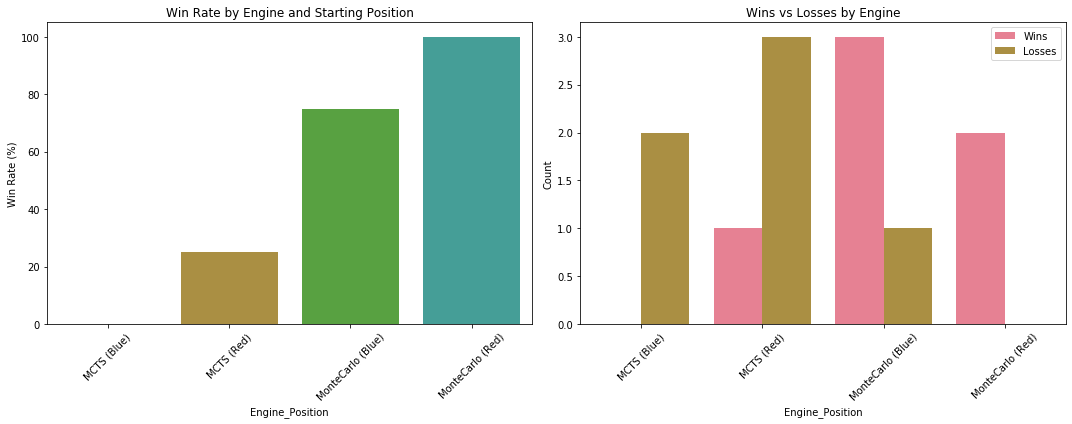

Win Rate Statistics:
            mean       std   min    max
EngineType                             
MCTS        12.5  17.67767   0.0   25.0
MonteCarlo  87.5  17.67767  75.0  100.0


In [15]:
# Win rate comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Win rate by engine and position
sns.barplot(data=df, x='Engine_Position', y='WinRate', ax=ax1)
ax1.set_title('Win Rate by Engine and Starting Position')
ax1.set_ylabel('Win Rate (%)')
ax1.tick_params(axis='x', rotation=45)

# Win/Loss distribution
win_loss_df = df.melt(id_vars=['Engine_Position'], 
                      value_vars=['Wins', 'Losses'], 
                      var_name='Result', value_name='Count')
sns.barplot(data=win_loss_df, x='Engine_Position', y='Count', hue='Result', ax=ax2)
ax2.set_title('Wins vs Losses by Engine')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical summary
print("Win Rate Statistics:")
win_rate_stats = df.groupby('EngineType')['WinRate'].agg(['mean', 'std', 'min', 'max'])
print(win_rate_stats)

## Performance Analysis (Time vs Win Rate)

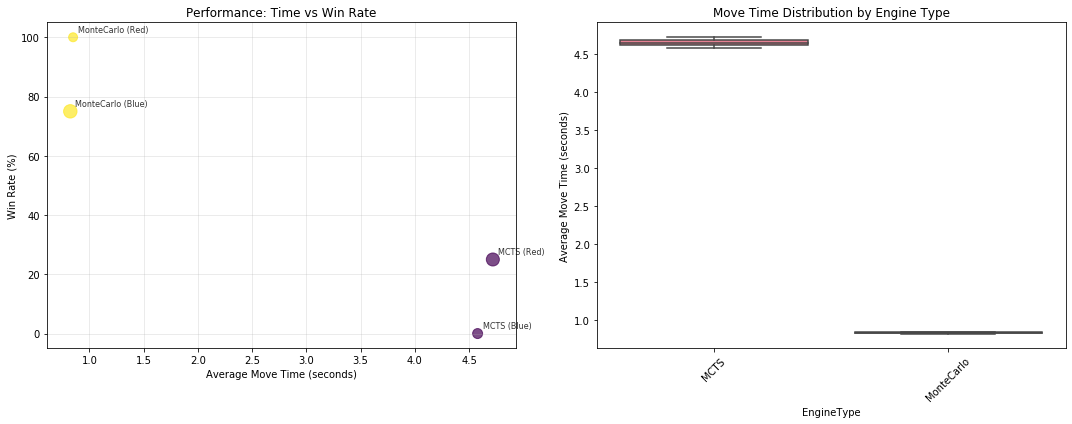

Correlation between Move Time and Win Rate:
Pearson correlation coefficient: -0.941


In [17]:
# Performance analysis: Time vs Win Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Time vs Win Rate
scatter = ax1.scatter(df['AvgMoveTimeSeconds'], df['WinRate'], 
                     c=pd.factorize(df['EngineType'])[0], 
                     s=df['TotalMoves']*10, alpha=0.7)
ax1.set_xlabel('Average Move Time (seconds)')
ax1.set_ylabel('Win Rate (%)')
ax1.set_title('Performance: Time vs Win Rate')
ax1.grid(True, alpha=0.3)

# Add labels for each point
for i, row in df.iterrows():
    ax1.annotate(row['Engine_Position'], 
                (row['AvgMoveTimeSeconds'], row['WinRate']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Performance by engine type
sns.boxplot(data=df, x='EngineType', y='AvgMoveTimeSeconds', ax=ax2)
ax2.set_title('Move Time Distribution by Engine Type')
ax2.set_ylabel('Average Move Time (seconds)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation analysis
print("Correlation between Move Time and Win Rate:")
correlation = df['AvgMoveTimeSeconds'].corr(df['WinRate'])
print(f"Pearson correlation coefficient: {correlation:.3f}")

## Starting Position Advantage Analysis

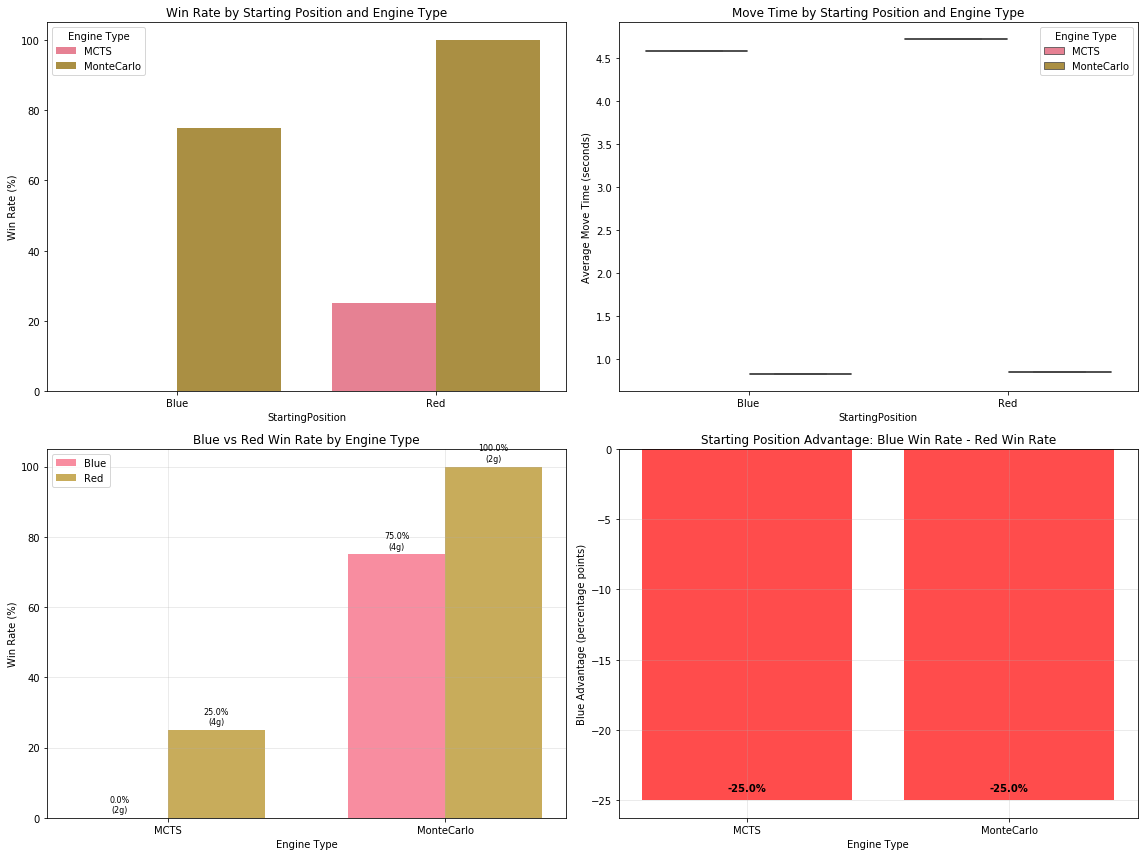

DETAILED STARTING POSITION ANALYSIS PER ENGINE

Performance by Engine and Starting Position:


WinRate  AvgMoveTimeSeconds  TotalMoves  \
EngineType StartingPosition                                            
MCTS       Blue                  0.0                4.58          10   
           Red                  25.0                4.72          17   
MonteCarlo Blue                 75.0                0.82          18   
           Red                 100.0                0.85           8   

                             TotalGames  
EngineType StartingPosition              
MCTS       Blue                       2  
           Red                        4  
MonteCarlo Blue                       4  
           Red                        2


Blue Advantage Summary:
--------------------------------------------------------------------------------
MCTS            | Red favored     | Blue:   0.0% ( 2 games) | Red:  25.0% ( 4 games) | Δ: -25.0%
MonteCarlo      | Red favored     | Blue:  75.0% ( 4 games) | Red: 100.0% ( 2 games) | Δ: -25.0%

KEY INSIGHTS
Overall Blue advantage: -25.0%
  (Blue: 37.5% vs Red: 62.5%)

Best as Blue: MonteCarlo (75.0%)
Best as Red:  MonteCarlo (100.0%)


In [19]:
# Analyze starting position advantage PER ENGINE
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Win rate by starting position for each engine
sns.barplot(data=df, x='StartingPosition', y='WinRate', hue='EngineType', ax=ax1)
ax1.set_title('Win Rate by Starting Position and Engine Type')
ax1.set_ylabel('Win Rate (%)')
ax1.legend(title='Engine Type')

# 2. Move time by starting position for each engine
sns.boxplot(data=df, x='StartingPosition', y='AvgMoveTimeSeconds', hue='EngineType', ax=ax2)
ax2.set_title('Move Time by Starting Position and Engine Type')
ax2.set_ylabel('Average Move Time (seconds)')
ax2.legend(title='Engine Type')

# 3. Win rate comparison: Blue vs Red for each engine
blue_red_comparison = []
for engine in df['EngineType'].unique():
    engine_data = df[df['EngineType'] == engine]
    blue_data = engine_data[engine_data['StartingPosition'] == 'Blue']
    red_data = engine_data[engine_data['StartingPosition'] == 'Red']
    
    blue_win_rate = blue_data['WinRate'].iloc[0] if len(blue_data) > 0 else 0
    red_win_rate = red_data['WinRate'].iloc[0] if len(red_data) > 0 else 0
    blue_games = blue_data['TotalGames'].iloc[0] if len(blue_data) > 0 else 0
    red_games = red_data['TotalGames'].iloc[0] if len(red_data) > 0 else 0
    
    blue_red_comparison.append({
        'Engine': engine,
        'Blue_WinRate': blue_win_rate,
        'Red_WinRate': red_win_rate,
        'Blue_Advantage': blue_win_rate - red_win_rate,
        'Blue_Games': blue_games,
        'Red_Games': red_games
    })
    
comparison_df = pd.DataFrame(blue_red_comparison)
x_pos = np.arange(len(comparison_df))
width = 0.35

ax3.bar(x_pos - width/2, comparison_df['Blue_WinRate'], width, label='Blue', alpha=0.8)
ax3.bar(x_pos + width/2, comparison_df['Red_WinRate'], width, label='Red', alpha=0.8)
ax3.set_xlabel('Engine Type')
ax3.set_ylabel('Win Rate (%)')
ax3.set_title('Blue vs Red Win Rate by Engine Type')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(comparison_df['Engine'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, (blue, red, blue_games, red_games) in enumerate(zip(
    comparison_df['Blue_WinRate'], comparison_df['Red_WinRate'],
    comparison_df['Blue_Games'], comparison_df['Red_Games'])):
    ax3.text(i - width/2, blue + 1, f'{blue:.1f}%\n({blue_games}g)', ha='center', va='bottom', fontsize=8)
    ax3.text(i + width/2, red + 1, f'{red:.1f}%\n({red_games}g)', ha='center', va='bottom', fontsize=8)

# 4. Starting position advantage by engine
colors = ['green' if x > 0 else 'red' for x in comparison_df['Blue_Advantage']]
bars = ax4.bar(comparison_df['Engine'], comparison_df['Blue_Advantage'], color=colors, alpha=0.7)
ax4.set_xlabel('Engine Type')
ax4.set_ylabel('Blue Advantage (percentage points)')
ax4.set_title('Starting Position Advantage: Blue Win Rate - Red Win Rate')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.grid(True, alpha=0.3)

# Add value labels
for bar, advantage in zip(bars, comparison_df['Blue_Advantage']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{advantage:+.1f}%', ha='center', va='bottom', fontsize=10,
             fontweight='bold' if abs(advantage) > 5 else 'normal')

plt.tight_layout()
plt.show()

print("="*50)
print("DETAILED STARTING POSITION ANALYSIS PER ENGINE")
print("="*50)

# Simple aggregated statistics without std
position_stats_by_engine = df.groupby(['EngineType', 'StartingPosition']).agg({
    'WinRate': 'first',
    'AvgMoveTimeSeconds': 'first',
    'TotalMoves': 'first',
    'TotalGames': 'first'
}).round(2)

print("\nPerformance by Engine and Starting Position:")
display(position_stats_by_engine)

print("\nBlue Advantage Summary:")
print("-" * 80)
for engine in df['EngineType'].unique():
    engine_data = df[df['EngineType'] == engine]
    blue_data = engine_data[engine_data['StartingPosition'] == 'Blue']
    red_data = engine_data[engine_data['StartingPosition'] == 'Red']
    
    if len(blue_data) > 0 and len(red_data) > 0:
        blue_win_rate = blue_data['WinRate'].iloc[0]
        red_win_rate = red_data['WinRate'].iloc[0]
        advantage = blue_win_rate - red_win_rate
        
        blue_games = blue_data['TotalGames'].iloc[0]
        red_games = red_data['TotalGames'].iloc[0]
        
        advantage_desc = "Blue favored" if advantage > 2 else "Red favored" if advantage < -2 else "Roughly equal"
        
        print(f"{engine:15} | {advantage_desc:15} | "
              f"Blue: {blue_win_rate:5.1f}% ({blue_games:2d} games) | "
              f"Red: {red_win_rate:5.1f}% ({red_games:2d} games) | "
              f"Δ: {advantage:+.1f}%")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Calculate overall Blue advantage
overall_blue_winrate = df[df['StartingPosition'] == 'Blue']['WinRate'].mean()
overall_red_winrate = df[df['StartingPosition'] == 'Red']['WinRate'].mean()
overall_advantage = overall_blue_winrate - overall_red_winrate

print(f"Overall Blue advantage: {overall_advantage:+.1f}%")
print(f"  (Blue: {overall_blue_winrate:.1f}% vs Red: {overall_red_winrate:.1f}%)")

# Find which engine handles the advantage best/worst
if len(comparison_df) > 0:
    best_blue_engine = comparison_df.loc[comparison_df['Blue_WinRate'].idxmax()]
    best_red_engine = comparison_df.loc[comparison_df['Red_WinRate'].idxmax()]
    
    print(f"\nBest as Blue: {best_blue_engine['Engine']} ({best_blue_engine['Blue_WinRate']:.1f}%)")
    print(f"Best as Red:  {best_red_engine['Engine']} ({best_red_engine['Red_WinRate']:.1f}%)")


## Efficiency Analysis (Moves per Game)

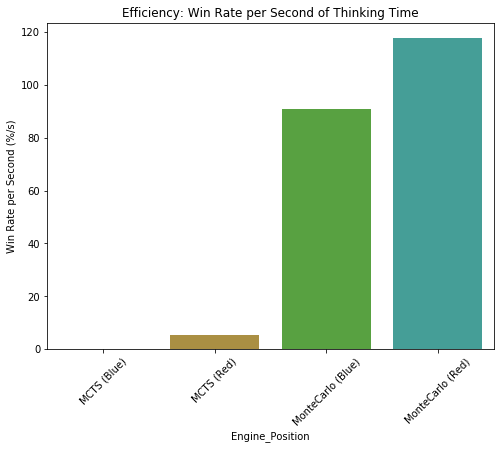

Efficiency Analysis:
     Engine_Position  WinRatePerSecond
0        MCTS (Blue)             0.000
1         MCTS (Red)             5.297
2  MonteCarlo (Blue)            90.969
3   MonteCarlo (Red)           117.639


In [21]:
# Efficiency analysis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Efficiency: Win Rate per Second
df['WinRatePerSecond'] = df['WinRate'] / df['AvgMoveTimeSeconds']
sns.barplot(data=df, x='Engine_Position', y='WinRatePerSecond', ax=ax)
ax.set_title('Efficiency: Win Rate per Second of Thinking Time')
ax.set_ylabel('Win Rate per Second (%/s)')
ax.tick_params(axis='x', rotation=45)

#plt.tight_layout()
plt.show()

print("Efficiency Analysis:")
efficiency_stats = df[['Engine_Position', 'WinRatePerSecond']].round(3)
print(efficiency_stats)

## Comparative Analysis: Engine vs Engine

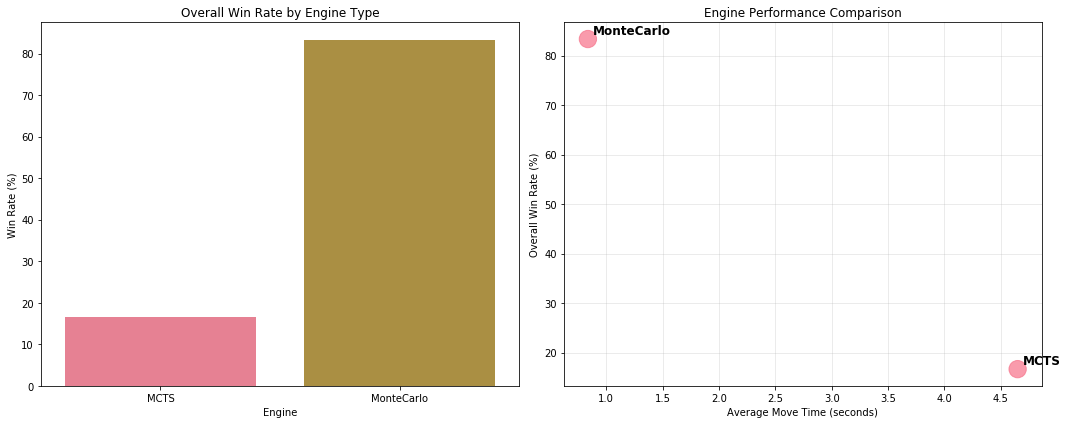

Engine Comparison Summary:


,Engine,AvgWinRate,AvgMoveTime,TotalWins,TotalGames,OverallWinRate
0,MCTS,12.5,4.65,1,6,16.67
1,MonteCarlo,87.5,0.84,5,6,83.33


In [23]:
# Create engine comparison matrix
engine_types = df['EngineType'].unique()
comparison_data = []

for engine in engine_types:
    engine_data = df[df['EngineType'] == engine]
    comparison_data.append({
        'Engine': engine,
        'AvgWinRate': engine_data['WinRate'].mean(),
        'AvgMoveTime': engine_data['AvgMoveTimeSeconds'].mean(),
        'TotalWins': engine_data['Wins'].sum(),
        'TotalGames': engine_data['TotalGames'].sum(),
        'OverallWinRate': (engine_data['Wins'].sum() / engine_data['TotalGames'].sum()) * 100
    })

comparison_df = pd.DataFrame(comparison_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall win rate by engine
sns.barplot(data=comparison_df, x='Engine', y='OverallWinRate', ax=ax1)
ax1.set_title('Overall Win Rate by Engine Type')
ax1.set_ylabel('Win Rate (%)')

# Performance comparison
ax2.scatter(comparison_df['AvgMoveTime'], comparison_df['OverallWinRate'], 
           s=comparison_df['TotalGames']*50, alpha=0.7)
ax2.set_xlabel('Average Move Time (seconds)')
ax2.set_ylabel('Overall Win Rate (%)')
ax2.set_title('Engine Performance Comparison')
ax2.grid(True, alpha=0.3)

# Add labels
for i, row in comparison_df.iterrows():
    ax2.annotate(row['Engine'], 
                (row['AvgMoveTime'], row['OverallWinRate']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

print("Engine Comparison Summary:")
display(comparison_df.round(2))

## Summary Statistics

In [25]:
# Comprehensive summary
print("=== COMPREHENSIVE SUMMARY ===")

print("1. Best Performing Engine:")
best_engine = df.loc[df['WinRate'].idxmax()]
print(f"   {best_engine['Engine_Position']} - {best_engine['WinRate']:.1f}% win rate")

print("2. Most Efficient Engine (Win Rate per Second):")
df['Efficiency'] = df['WinRate'] / df['AvgMoveTimeSeconds']
most_efficient = df.loc[df['Efficiency'].idxmax()]
print(f"   {most_efficient['Engine_Position']} - {most_efficient['Efficiency']:.3f} %/s")

print("3. Starting Position Advantage:")
blue_advantage = df[df['StartingPosition'] == 'Blue']['WinRate'].mean() - df[df['StartingPosition'] == 'Red']['WinRate'].mean()
print(f"   Blue advantage over Red: {blue_advantage:+.1f}%")

print("4. Detailed Statistics by Engine:")
summary = df.groupby('EngineType').agg({
    'WinRate': ['mean', 'std', 'count'],
    'AvgMoveTimeSeconds': ['mean', 'std'],
    'TotalMoves': 'sum'
}).round(2)
print(summary)

=== COMPREHENSIVE SUMMARY ===
1. Best Performing Engine:
   MonteCarlo (Red) - 100.0% win rate
2. Most Efficient Engine (Win Rate per Second):
   MonteCarlo (Red) - 117.639 %/s
3. Starting Position Advantage:
   Blue advantage over Red: -25.0%
4. Detailed Statistics by Engine:
           WinRate              AvgMoveTimeSeconds       TotalMoves
              mean    std count               mean   std        sum
EngineType                                                         
MCTS          12.5  17.68     2               4.65  0.10         27
MonteCarlo    87.5  17.68     2               0.84  0.02         26
